# Introduction

In this project we will implement the Adaboost machine learning model using decision stumps as our weak learner.

# Setup

## Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from matplotlib.ticker import FuncFormatter
import pickle

## Loading dataset

Here we will create a pandas Dataframe with all the data

In [3]:
column_names = [
    "tl", "tm", "tr",
    "ml", "mm", "mr",
    "bl", "bm", "br",
    "target"
]

data = pd.read_csv("tic-tac-toe.data", header=None, names=column_names)

data

,tl,tm,tr,ml,mm,mr,bl,bm,br,target
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


Here we will separate the features (X) and the targets (y)

In [4]:
y = data['target']
X = data.drop('target', axis=1).values

X

array([['x', 'x', 'x', ..., 'x', 'o', 'o'],
       ['x', 'x', 'x', ..., 'o', 'x', 'o'],
       ['x', 'x', 'x', ..., 'o', 'o', 'x'],
       ...,
       ['o', 'x', 'o', ..., 'x', 'o', 'x'],
       ['o', 'x', 'o', ..., 'x', 'o', 'x'],
       ['o', 'o', 'x', ..., 'o', 'x', 'x']], dtype=object)

Now, let's convert the targets from positive and negative values to 1 and -1 values, respectively:

In [5]:
mapping = {'positive': 1, 'negative': -1}

y = y.map(mapping).values

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

## Spliting data for cross validation

For this project we will use 5-Fold Cross Validation to compare what is the optimal number of weak learners for our Adaboost model. Below, we will create the 5 folds our data will be split into:

In [6]:
folds_5 = KFold(n_splits=5, shuffle=True, random_state=1)

# Creating the Decision Stump

Here we will make the class that models the decision stumps:

In [7]:
class DecisionStump:
	def __init__(self):
		self.polarity = 1
		self.feature_column_number = None
		self.threshold = None
		self.alpha = None

	def predict(self, features):
		data_length = features.shape[0]
		feature_column = features[:, self.feature_column_number]
		outputs = np.ones(data_length)
		if self.polarity == -1:
			outputs[feature_column != self.threshold] = -1
		else:
			outputs[feature_column == self.threshold] = -1
		return outputs

# Creating the Adaboost model

Now we will create a class that will model the Adaboost model

In [8]:
class AdaBoost:
    def __init__(self, number_of_learners=None, model=None):
        if model is not None:
            self.number_of_learners = len(model)
            self.model = model
        elif number_of_learners is not None:
            self.number_of_learners = number_of_learners
            self.model = []
        else:
            raise ValueError("You must provide either number_of_learners or model")

    def caclulate_alpha(self, error):
        INFINITESIMAL = 1e-10
        return 0.5 * np.log((1.0 - error) / (error + INFINITESIMAL))
    
    def calculate_weights(self, learner, target, outputs, weights):
        weights *= np.exp(-learner.alpha * target * outputs)
        weights /= np.sum(weights)
        return  weights

    def select_best_learner(self, features, weights, target):
        learner = DecisionStump()
        best_learner_error = float('inf')
        data_length = features.shape[0]
        number_of_features = features.shape[1]
        for feature_column_number in range(number_of_features):
            feature_column = features[:, feature_column_number]
            thresholds = np.unique(feature_column)
            for threshold in thresholds:
                polarity = 1
                outputs = np.ones(data_length)
                outputs[feature_column == threshold] = -1
                learner_error = sum(weights[target != outputs])
                if learner_error > 0.5:
                    learner_error = 1 - learner_error
                    polarity = -1
                if learner_error < best_learner_error:
                    learner.polarity = polarity
                    learner.threshold = threshold
                    learner.feature_column_number = feature_column_number
                    best_learner_error = learner_error
        return learner, best_learner_error
    
    def predict(self, features):
        learner_outputs = [model.alpha * model.predict(features) for model in self.model]
        model_output = np.sum(learner_outputs, axis=0)
        model_output = np.sign(model_output)
        return model_output
    
    def add_learner_to_model(self, features, target, weights):
        best_learner, best_learner_error = self.select_best_learner(features, weights, target)
        best_learner.alpha = self.caclulate_alpha(best_learner_error)
        outputs = best_learner.predict(features)
        weights = self.calculate_weights(best_learner, target, outputs, weights)
        self.model.append(best_learner)
        return weights
    
    def model_eval(self, features, target):
        outputs = self.predict(features)
        error = sum(outputs != target)
        accuracy = 1 - (error / features.shape[0])
        return error, accuracy

    def fit(self, features, target):
        if self.model:
            raise ValueError("Model already trained")
        data_length = features.shape[0]
        weights = np.full(data_length, (1 / data_length))
        for _ in range(self.number_of_learners):
            weights = self.add_learner_to_model(features, target, weights)
        return self.model_eval(features, target)
    
    def get_number_of_learners(self):
        return self.number_of_learners

# Training and testing the models

Here we will train models using 5-fold cross validation and simultaneosly test them. Will will do this for different numbers of weak learners to evaluate the which of them yield the optimal result.

In [109]:
learner_number_options = [i for i in range(1, 351)]
mean_train_errors = []
mean_train_accuracies = []
mean_test_errors= []
mean_test_accuracies = []
print('--> Running... <--')
for i, learner_option in enumerate(learner_number_options):
    train_errors = []
    train_accuracies = []
    test_errors = []
    test_accuracies = []
    all_train_results = []
    for train_indices, val_indices in folds_5.split(X):
        features_train, features_valid = X[train_indices], X[val_indices]
        targets_train, targets_valid = y[train_indices], y[val_indices]
        model = AdaBoost(number_of_learners=learner_option)
        train_error, train_accuracy = model.fit(features_train, targets_train)
        train_errors.append(train_error)
        train_accuracies.append(train_accuracy)
        output = model.predict(features_valid)
        test_error = sum(output != targets_valid)
        test_errors.append(test_error)
        test_accuracy = 1 - (test_error / features_valid.shape[0])
        test_accuracies.append(test_accuracy)
    mean_train_error = np.mean(train_errors)
    mean_train_errors.append(mean_train_error)
    mean_train_accuracy = np.mean(train_accuracies)
    mean_train_accuracies.append(mean_train_accuracy)
    mean_test_error = np.mean(test_errors)
    mean_test_errors.append(mean_test_error)
    mean_test_accuracy = np.mean(test_accuracies)
    mean_test_accuracies.append(mean_test_accuracy)
    # Print progress every 50 learners or at end
    if i % 50 == 0 or i == len(learner_number_options) - 1:
        print(f'#################### Model with {learner_option} learners ####################')
        print(f'Train Results --> Train Error: {mean_train_error:.2f}, Train Accuracy: {(mean_train_accuracy * 100):.4f}%')
        print(f'Test Results --> Test Error: {mean_test_error:.2f}, Test Accuracy: {(mean_test_accuracy * 100):.4f}%')
print('--> Finished <--')
# save mean test and train errors and accuracies to pickle file
results = {
    'learner_number_options': learner_number_options,
    'mean_train_errors': mean_train_errors,
    'mean_train_accuracies': mean_train_accuracies,
    'mean_test_errors': mean_test_errors,
    'mean_test_accuracies': mean_test_accuracies
}
with open('results/results.pkl', 'wb') as f:
    pickle.dump(results, f)

--> Running... <--
#################### Model with 1 learners ####################
Train Results --> Train Error: 230.40, Train Accuracy: 69.9374%
Test Results --> Test Error: 57.60, Test Accuracy: 69.9373%
#################### Model with 51 learners ####################
Train Results --> Train Error: 125.80, Train Accuracy: 83.5851%
Test Results --> Test Error: 33.80, Test Accuracy: 82.3555%
#################### Model with 101 learners ####################
Train Results --> Train Error: 69.80, Train Accuracy: 90.8924%
Test Results --> Test Error: 20.80, Test Accuracy: 89.1405%
#################### Model with 151 learners ####################
Train Results --> Train Error: 25.20, Train Accuracy: 96.7116%
Test Results --> Test Error: 9.20, Test Accuracy: 95.1952%
#################### Model with 201 learners ####################
Train Results --> Train Error: 14.20, Train Accuracy: 98.1472%
Test Results --> Test Error: 4.80, Test Accuracy: 97.4935%
#################### Model with 251 lea

# Analysis

Here we will analyze both training and test performance for the different models (different number of learners) and see how they compare. 

## Loading the results

First we will load the results from training and testing:

In [9]:
# load results dict from pickle file
with open('results/results.pkl', 'rb') as f:
    results = pickle.load(f)
learner_number_options = results['learner_number_options']
mean_train_errors = results['mean_train_errors']
mean_train_accuracies = results['mean_train_accuracies']
mean_test_errors = results['mean_test_errors']
mean_test_accuracies = results['mean_test_accuracies']

## Analyzing the mean train and test error

Here we will compare the mean train and test error for the different models (different number of learners). Notice that we are using mean error and not simply error because that we used 5-fold cross validation.

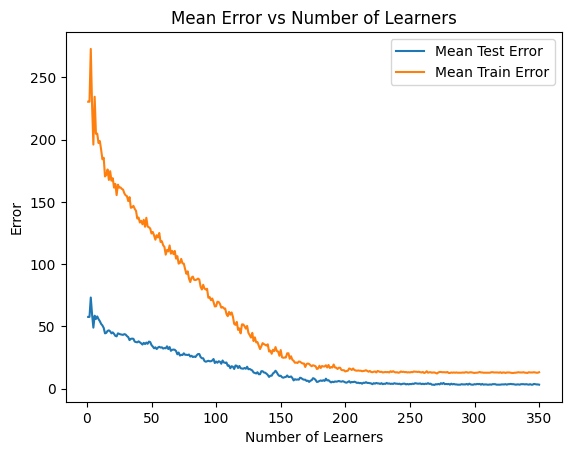

In [10]:
plt.plot(learner_number_options, mean_test_errors, label='Mean Test Error')
plt.plot(learner_number_options, mean_train_errors, label='Mean Train Error')
plt.xlabel('Number of Learners')
plt.ylabel('Error')
plt.title(f'Mean Error vs Number of Learners')
plt.legend()
plt.savefig('plots/error.png')
plt.show()

- Initial Phase of Learning:

In the beginning, each additional learner (e.g., decision tree) has a significant impact on the model's performance. This is because the model starts from a relatively poor baseline, due to decision stumps being high in bias. For each new learner added, it can capture substantial patterns in the data that the previous ones missed, lowering the bias.

- Diminishing Returns:

As the number of learners increases, the model becomes more refined and captures most of the significant patterns in the data. At this point, each new learner has less room to improve the model's performance because the remaining errors are harder to correct and may be due to noise or inherent limitations in the data.

- Convergence:

Eventually, the model reaches a convergence point where adding more learners doesn't significantly improve the training error. The error plateaus because the model has learned as much as it can from the data given. This is because the inate simplicity of using weak learners such as decision stumps in adaboost models gives it a capacity that is not sufficient to memorize the data. This is not a disadvatage to the model, but it's a feature, given that it generalizes well.

- Difference Between Test and Train Error:

As you can see, the test error is lower than the train error. This is due to the smaller dataset on which the test error was calculated on. Below, we compare test and train error relative to the datasets they were calculated on for a more fair comparison.

## Analyzing the mean train and test accuracy

Here we will compare the mean train and test accuracy for the different models (different number of learners). In contrast with the error metric, the accuracy metric will give us a better idea of how the model performance changes on unseen data. Again, we are using mean error and not simply error because we used 5-fold cross validation.

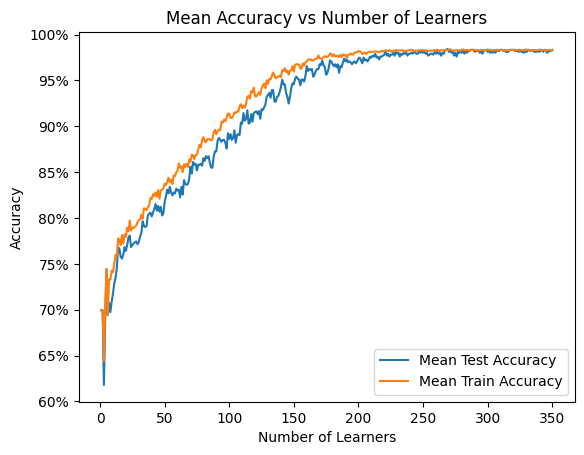

In [11]:
def percentage_formatter(x, pos):
    return f'{x:.0f}%'
scaled_mean_train_accuracies = [acc * 100 for acc in mean_train_accuracies]
scaled_mean_test_accuracies = [acc * 100 for acc in mean_test_accuracies]
fig, ax = plt.subplots()
ax.plot(learner_number_options, scaled_mean_test_accuracies, label='Mean Test Accuracy')
ax.plot(learner_number_options, scaled_mean_train_accuracies, label='Mean Train Accuracy')
ax.set_xlabel('Number of Learners')
ax.set_ylabel('Accuracy')
ax.set_title('Mean Accuracy vs Number of Learners')
ax.legend()
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.savefig('plots/accuracy.png')
plt.show()

- Difference Between Test and Train Error:

As expected, the model performance for the test data was lower than for the training data in general.

- Convergence:

As we can see, as the number of learners increase, the test and train error converge to the same accuracy, indicating that the model generalizes well for unseen data. This is a typical characteristic of adaboost models given that the use of weak learners avoids high variance and overfitting.

## Finding the best model

Here we will find the best model, or in other words, what is the optimal number of learners:

In [12]:
best_mean_test_error = min(mean_test_errors)
best_learner_option_index = mean_test_errors.index(best_mean_test_error)
best_learner_option = learner_number_options[best_learner_option_index]
best_mean_test_accuracy = mean_test_accuracies[best_learner_option_index]
print('##### Finding Best Results #####')
print(f'Best model number of learners: {best_learner_option}')
print(f'Best model mean error: {best_mean_test_error:.2f}')
print(f'Best model mean accuracy: {(best_mean_test_accuracy * 100):.4f}%')

##### Finding Best Results #####
Best model number of learners: 269
Best model mean error: 3.00
Best model mean accuracy: 98.4342%


- Performance:

With a 98.4342% accuracy, we can see how the model has a very satisfactory performance while generalizing very well. 

- Convergence:

As observed in the plots, with the increase of weak learners, the model performance converges to an optimal number of learners (269) well before adding the 350 learners that were intended intially.

# Final Results

- In this project we divided the data using cross validation to compare different adaboost models to select the optimal number of weak learners. In doing so, we were also able to have more reliable estimates and maximize data utilization all due to the cross validation.

- As we have seen from before, the model with best performance was the model with 269 decision stumps with an accuracy of 98.4342%. Although there were other models with the same performance, the decision model with 269 decision stumps was the least complex of them and had lower variance, therefore being the most desirable model.

- The plots showed us that the train and test performance converged, indicating that the model generalized well with unseen data, which is due to the use of a collection of weak learners as explained below.

- By using a collection of weak learners, the adaboost model has:
    - Low variance and good generalization due to using weak learners
    - Low bias through the use of many weak learners
  In that sense, the adaboost model can have 'the best of both worlds'.

- In conclusion, by leveraging a collection of weak learners, the AdaBoost model successfully balanced low variance and low bias, achieving optimal generalization and robustness. This highlights the effectiveness of AdaBoost in harnessing the strengths of weak learners to create a powerful and reliable predictive model.